# Graph-based neural network architectures in NLP
<sup>This notebook is a part of Natural Language Processing class at the University of Ljubljana, Faculty for computer and information science. The content was prepared by Timotej Knez - [timotej.knez@fri.uni-lj.si](mailto:timotej.knez@fri.uni-lj.si). Please contact [slavko.zitnik@fri.uni-lj.si](mailto:slavko.zitnik@fri.uni-lj.si) for any comments.</sub>

## Graph neural networks
Graph neural networks are neural networks that accept graphs as inputs. Their goal is to encode information about the local structure of the graph around a node in a vector that represents each node. Depending on the task the output of a graph neural network can be embeddings for each node or a single vector for an entire graph.

### Graph
A graph consists of nodes that are connected with edges. When talking about graph neural networks each node is represented by a vector of features. If the nodes do not have any features associated with them, we can generate generic feature vectors (vector of size 1 with value 1, or unit vectors of size n where n is the number of nodes).

![](graph.png)

Nodes and edges can have features. Node features are required for graph neural networks, while some implementations of the graph convolutions can also use the edge features:
![](graph-features.png)

The edge features can have different complexities:
- binary: nodes are/are not connected
- multiple edge types: each edge is assigned a type
- single continuous value: each edge has a weight
- feature vectors: each edge has a vector of features (this is the most complex)

### Graph convolution
The idea behind graph neural networks is that on each step a node gets some information from its neighbours. This way the node learns information about the local graph structure as well as the features of the nearby nodes.

#### Performing a graph convolution operation
**General process**:
1. Take feature vectors of neighbours
    - Defined by the adjacency matrix
    - Can also include self loops
2. Transform feature vectors
    - Usually a single layer is used for transformation
    - The weights for the transformation are shared between all nodes (that makes this operation a convolution)
4. Aggregate feature vectors
    - Aggregation function needs to be order invariant (the order of neighbours should not matter)
    - The aggregation function can include attention mechanism to weight the neighbours
    - The most common aggregation function is SUM with some normalization (based on the number of neighbours)
5. Update
    - Include the original feature vector
    - Not strictly necessary (we can replace this step with self loops)

![](aggregation.png)

The end result of the graph convolutions is a graph where the feature vectors of the nodes are different. This is useful when our goal is to predict some characteristic of a node. In some cases we would like to predict characteristic of an entire graph.
#### Graph classification
When predicting graph level features our goal is to end up with a single vector that describes the entire graph. We achieve this by using pooling layers. The common pooling mechanisms are to compute the average or a maximum of the node vectors. In some cases we loose too much information by pooling over the entire graph. In these cases it might be useful to divide the nodes in a graph into multiple groups and do the pooling operation over each group separately. This way we end up with a smaller graph where we can repeat the pooling part until we get a single vector.

### Graph neural networks for NLP
We can represent a text document as a graph. This way we can take advantage of a graph neural network to analyze the document. Depending on the application there are multiple ways to represent a document as a graph. In this tutorial we will compute a dependency tree and use the dependencies as the edges between the tokens.
![](sentence-graph.png)

For implementing the grpah neural networks we will be using PyTorch geometric library. This is a library built on top of the PyTorch library.
PyTorch geometric requires the following libraries, to work properly:
- torch-scatter
- torch-sparse
- torch-cluster
- torch-geometric

When using CUDA acceleration, make sure you are using a supported version (read more on [PyTorch Github](https://github.com/pyg-team/pytorch_geometric))

In [ ]:
# Install the torch-geometric package 

# PIP
#!pip install --no-cache-dir torch-scatter
#!pip install --no-cache-dir torch-sparse
#!pip install --no-cache-dir torch-cluster
#!pip install torch-geometric

# Conda
!conda install pyg -c pyg

In [1]:
from datetime import datetime
import spacy
import pandas
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np

# torch geometric libraries
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch_geometric.nn as pyg_nn
from torch_geometric.graphgym import optim
import torch_geometric.utils as pyg_utils

nlp = spacy.load("en_core_web_lg")
vector_size = 300  # the size of token vector representation s in en_core_web_lg model

### Representing a document as a graph
We will use the spacy library to split the document into tokens, compute token embeddings and to get the dependencies between tokens.

The process of building a graph:
- Split text into tokens
- Tokens become nodes in a graph
- Calculate embedding for each token
- Use dependencies between tokens as edges

In [2]:
# Using spacy to get a dependency tree
doc = nlp("Today is a very sunny day.")
for token in doc:
    print(token.head, "->", token)
spacy.displacy.render(doc, style='dep')

is -> Today
is -> is
day -> a
sunny -> very
day -> sunny
is -> day
is -> .


### Obtaining token embeddings:
In order to use graph neural networks effectively, we need some vectors that represent the nodes. In our case the nodes represent individual tokens, so we can use token embeddings to represent nodes. The quality of the embeddings has a large effect on the performance of the model. Spacy already provides a way to get token embeddings by using the **vector** attribute of the token class. The embeddings that we get depend on the language model that we use. We will use the vectors provided by the **en_core_web_lg** model. The model provides 300 dimensional vectors for 685k unique tokens. The vectors are computed using the word2vec algorithm.

In [3]:
# Compute token embeddings
for token in nlp("Today is a very sunny day."):
    print(token, ":", token.vector.size)

Today : 300
is : 300
a : 300
very : 300
sunny : 300
day : 300
. : 300


Now let's create a function that accepts a text document and builds a syntax graph using the methods that we have seen.
The graph will be presented using a torch geometric **Data** object which helps us with training the model. Mainly it provides an automatic way to batch multiple graphs together. The Data object contains some predefined attributes like x (node embeddings), edge_index (representation of graph edges) and y (graph or node target class). We can also define our own attributes. In this example we will use text attribute to store the original text of the document and the root_index attribute to store the index of the node in a graph representing the root of a sentence (the main verb).

In [4]:
def text_to_graph(text, y):
    edge_index = []  # list of all edges in a graph
    doc = nlp(text)
    root = 0
    for token in doc:
        edge_index.append([token.i, token.i])  # add a self loop
        if token.i == token.head.i:
            root = token.i
        else:
            edge_index.append([token.i, token.head.i])  # add a connection from token to its parent
            edge_index.append([token.head.i, token.i])  # add a reverse connection
    x = torch.tensor(np.array([d.vector for d in doc]))  # compute token embedings
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()  # torch geometric expects to get the edges in a matrix with to rows and a column for each connection
    data = Data(x=x, edge_index=edge_index, y=torch.tensor([y]), text=text, root_index=root)
    return data

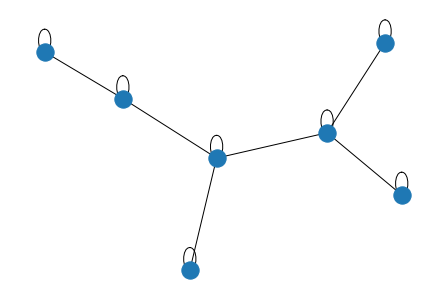

In [5]:
# visulise the graph
import networkx as nx
graph = text_to_graph("Today is a very sunny day.", 0)
g = pyg_utils.to_networkx(graph, to_undirected=True)
nx.draw(g)

### Sentiment analysis on yelp reviews:
We will be using a modified version of the yelp reviews dataset. The modified version was created for paper [From Group to Individual Labels using Deep Features](http://www.datalab.uci.edu/papers/kdd2015_dimitris.pdf) and is availablek in [this github repository](https://github.com/microsoft/ML-Server-Python-Samples/blob/master/microsoftml/202/data/sentiment_analysis/yelp_labelled.txt). The dataset contains 1000 reviews that are marked as positive or negative. The classes in the dataset are balanced (we have 500 positive and 500 negative reviews).

In [6]:
# Read the data
columns_name = ['text', 'class']
data_yelp = pandas.read_csv('yelp_labelled.txt', sep='\t', header=None)
data_yelp.columns = columns_name
print(data_yelp.head(10))

                                                text  class
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1
5     Now I am getting angry and I want my damn pho.      0
6              Honeslty it didn't taste THAT fresh.)      0
7  The potatoes were like rubber and you could te...      0
8                          The fries were great too.      1
9                                     A great touch.      1


In [7]:
# We use a standard pytorch dataset
import random
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        # the pandas dataframe on the input contains a column labeled 'text' with yelp review texts
        # the column labeled 'class' contains a number representing the polarity of the review (positive / negative)
        self.graphs = []
        self.num_node_features = vector_size
        self.num_classes = 2
        for text, y in zip(df['text'], df['class']):
            self.graphs.append(text_to_graph(text, y))
        random.Random(1).shuffle(self.graphs)

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

In [8]:
# Construct the dataset.
dataset = Dataset(data_yelp)
print(len(dataset))

1000


So flavorful and has just the perfect amount of heat.


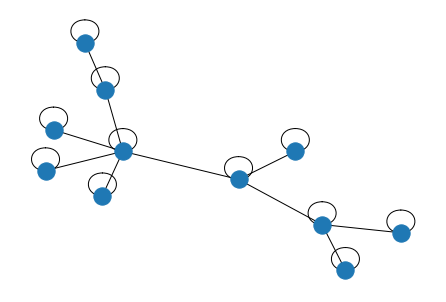

In [9]:
# visualise the first document in a dataset
graph = dataset[0]
print(graph.text)
g = pyg_utils.to_networkx(graph, to_undirected=True)
nx.draw(g)

### Creating the neural network
**Graph convolutions**:
There are many different implementations for computing graph convolutions implemented in PyTorch geometric library. We will take a look at the *GCNConv* layer since it is the most basic and simple to understand convolutional layer.
**Initialization**: We provide the size of the node embeddings on the input and the size of node embeddings on the output.
**Running**: GCNConv accepts a matrix representing node embeddings and the edge index matrix. It returns the matrix of new embeddings.

Other types of convolutions can be found in the [PyTorch geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html)
Some more useful ones include:
- **GCNConv** is the basic implementation of the layer that we described above.
- **RGCNConv** supports multiple edge types. When using it we can provide additional argument called *edge_type* that holds a list of all edge types as integers.
- **GINConv** convolution layer accepts a *nn* parameter that defines a module that is used to transform a node vector after the aggregation in the convolution step.
- **GINEConv** is a modified version of GINConv. It adds support for edge features. It accepts the *edge_attr* parameter that defines the features for each edge in the *edge_index* matrix.
- **GATConv** allows the use of attention when computing convolution operations.

In [10]:
# performing a graph convolution
graph = dataset[0]

input_dim = vector_size
output_dim = 5
convolution = pyg_nn.GCNConv(input_dim, output_dim)
print(convolution(graph.x, graph.edge_index))

tensor([[ 0.0571, -0.3243, -0.6823,  0.2715,  0.0813],
        [ 0.1641, -0.0633, -0.7897,  0.3538,  0.3257],
        [ 0.0808, -0.0962, -0.5513,  0.2738,  0.3776],
        [ 0.0581, -0.0112, -0.6144,  0.4025,  0.0605],
        [-0.0783,  0.0136, -0.4758,  0.0856, -0.0839],
        [ 0.1376, -0.0712, -0.3607,  0.1918,  0.1719],
        [-0.1004, -0.6270, -0.1776,  0.5065, -0.0517],
        [ 0.2107, -0.2743, -0.7426,  0.4422,  0.2423],
        [-0.1302, -0.0342, -0.1082,  0.1528,  0.3383],
        [-0.0680, -0.0197,  0.0011,  0.0979,  0.4880],
        [ 0.1639,  0.2019, -0.3586,  0.3017,  0.1360]], grad_fn=<AddBackward0>)


#### Working with batches:
One of the challenges that we commonly come across when working with graph neural networks is how to group nodes in batches to be computed in parallel. The **torch_geometric.loader.DataLoader** class helps us with this by grouping graphs together into a larger batch.
The DataLoader class automatically transforms the node features (x) and the edge matrix (edge_index) to generate a larger graph made up of the original graphs in a batch. It also adds the *batch* attribute that records the batch that each node came from. The transformation applied to custom attributes depends on their name. By default, the result will be a list of values from all graphs. For example elements with the word *index* in their name will get automatically incremented.
![](batching.png)

In [11]:
dataloader = DataLoader(dataset, batch_size=16)
batch = next(iter(dataloader))
print(batch)
print(batch.batch)

DataBatch(x=[218, 300], edge_index=[2, 616], y=[16], text=[16], root_index=[16], batch=[218], ptr=[17])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13,
        13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15,
        15, 15, 

#### Building the model
We define the neural network architecture with teh following layers:
- convolution 300 -> 16
- layer normalization
- convolution layer 16 -> 16
- layer normalization
- convolution layer 16 -> 16
- pooling
- linear 16 -> 16
- dropout layer
- linear 16 -> 2

![](network.png)
By using 3 graph convolutional layers, each node will contain information from nodes that are at most 3 steps away.

In [12]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, pooling_type='pooling', dropout=0.25):
        super(GNNStack, self).__init__()
        self.pooling_type = pooling_type
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        for l in range(2):
            self.lns.append(nn.LayerNorm(hidden_dim))
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = dropout
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        return pyg_nn.GCNConv(input_dim, hidden_dim)

    def forward(self, data):
        x, edge_index, batch, root = data.x, data.edge_index, data.batch, data.root_index
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x=x, edge_index=edge_index)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.pooling_type == 'pooling':
            x = pyg_nn.global_mean_pool(x, batch)
        else:
            x = x[root]

        x = self.post_mp(x)

        return F.log_softmax(x, dim=1)
        # return F.softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)
        # return F.cross_entropy(pred, label)

#### Training a model
Training the graph neural network is largely the same as training any other pytorch network. We split the dataset into training and testing part. We will use Adam optimizer to optimize the weights in the network. Every 10 epochs we also test the preformance of the model on the test data.

In [13]:
def train(dataset, pooling_type, writer, dropout=0.25, weight_decay=0):
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 16, dataset.num_classes, pooling_type=pooling_type, dropout=dropout)
    opt = optim.Adam(model.parameters(), lr=0.0001, weight_decay=weight_decay)

    # train
    for epoch in range(101):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc, test_prec, test_rec, test_f1 = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
def test(loader, model, is_validation=False):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for data in loader:
            pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y
            predictions += pred.tolist()
            labels += label.tolist()

    total = len(loader.dataset)
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions)
    precision = precision_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return accuracy, precision, recall, f1

#### Getting a single embedding for the entire graph
If we want to perform classification over the entire sentence and not just one word, we have to somehow aggregate the information captured in all token embeddings. The more general approach for getting information about the entire graph is to use pooling. In our example we use mean pooling, which simpli computes the mean of all token embeddings.
On the other hand we can take advantage of the fact that our graphs are shaped like trees, so we can use the root node to aggregate the information from all nodes in a graph. In this case we will get the sentence embedding by taking the embedding of the root word.

In [15]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
# classification_type = 'root'
classification_type = 'pooling'
model = train(dataset, classification_type, writer, dropout=0.25, weight_decay=0.001)

Epoch 0. Loss: 0.7043. Test accuracy: 0.4650
Epoch 10. Loss: 0.6633. Test accuracy: 0.7100
Epoch 20. Loss: 0.5205. Test accuracy: 0.8300
Epoch 30. Loss: 0.3907. Test accuracy: 0.8400
Epoch 40. Loss: 0.3347. Test accuracy: 0.8200
Epoch 50. Loss: 0.2988. Test accuracy: 0.8350
Epoch 60. Loss: 0.2712. Test accuracy: 0.8400
Epoch 70. Loss: 0.2422. Test accuracy: 0.8350
Epoch 80. Loss: 0.2232. Test accuracy: 0.8300
Epoch 90. Loss: 0.2126. Test accuracy: 0.8450
Epoch 100. Loss: 0.1935. Test accuracy: 0.8450


#### Testing the model
We expect to achieve an accuracy between 83% and 85%, which is comparable to the results presented in the paper where the dataset was developed. Their proposed method achieved an accuracy of 88%.

In [16]:
test_acc, test_prec, test_rec, test_f1 = test(DataLoader(dataset[int(len(dataset) * 0.8):], batch_size=64, shuffle=True), model, is_validation=True)
print("Accuracy: {:.2f}\n"
      "Precision: {:.2f}\n"
      "Recall: {:.2f}\n"
      "F1: {:.2f}".format(test_acc, test_prec, test_rec, test_f1))

Accuracy: 0.84
Precision: 0.86
Recall: 0.85
F1: 0.85


In [17]:
# Visualising the network
from torchviz import make_dot
res = model(dataset[0])
make_dot(res, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

'rnn_torchviz.png'

Further reading:
- Using a graph neural network for classification of temporal relations between events: [Event Temporal Relation Extraction with Attention Mechanism and Graph Neural Network](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9515702)
- Graph neural networks tutorial by Stanford University: [Jupyter notebook](https://colab.research.google.com/drive/1DIQm9rOx2mT1bZETEeVUThxcrP1RKqAn)